# Compute the style of an image

Based on the paper by Gatis et al. 2016 ([ref](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)).
other refs:
https://arxiv.org/abs/1606.01286
https://arxiv.org/abs/1603.08155

Improvment:

- compute gram only on inner part of the image (e.g. 3:-3), that might fix some issues with the stability of jittering
- randomly cancel or *.1 some features (i.e. row and column of gram matrix) when computing the styloe loss

In [3]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Get images

(-0.5, 499.5, 727.5, -0.5)

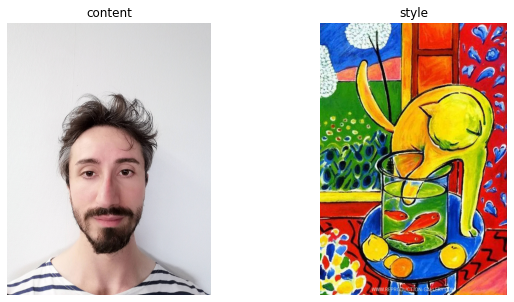

In [16]:
# content_im = skimage.data.coffee()
content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/IMG_20210617_094559.jpg?raw=true")
# content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/IMG_20210317_085429_b.jpg?raw=true")
# content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/Cecile2.jpg?raw=true")
# style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/hokusai_wave.png?raw=true")
# style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/miro_breakofday.jpeg?raw=true")
style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/matisse_cat.jpeg?raw=true")
# style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/GeorgiaOkeeffe1925.jpeg?raw=true")


# style_im = skimage.io.imread("https://github.com/jcjohnson/fast-neural-style/blob/master/images/styles/composition_vii.jpg?raw=True")

fig, ax = plt.subplots(1,2,figsize=[10,5])
plt.sca(ax[0])
_ = plt.imshow(content_im); plt.title("content"); plt.axis("off")
plt.sca(ax[1])
_ = plt.imshow(style_im); plt.title("style"); plt.axis("off")

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [17]:
# From D2L
# im_shape = (128,128)
# im_shape = (128,128)
# im_shape = (128+16,128)
# im_shape = (128,128)
# im_shape = (256,256+64)
im_shape = (96,96)
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    with torch.no_grad():
        img = img[0].to(rgb_std.device).clone()
#         img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
#         img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
#     return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))
    return torchvision.transforms.ToPILImage()(img.permute(1, 2, 0).permute(2, 0, 1))

# Get a pretrained model

In [18]:
pretrained_net = torchvision.models.vgg16(pretrained=True)
# pretrained_net = torchvision.models.vgg19(pretrained=True)
pretrained_net.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kerne

# Defined the image generator network and a function to make a partial pass through the network

In [19]:
class ImageGenerator(nn.Module):
    def __init__(self,image):
        super(ImageGenerator,self).__init__()
        # self.im = nn.Parameter(torch.rand(1, 3, *shape))
        self.im = nn.Parameter(image)

        # self.transform = torchvision.transforms.RandomAffine((-0.001,0.001), translate=(1./im_shape[1],1./im_shape[0]), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        self.jit_i = 0.0
        self.jit_j = 0.0
        self.angle=0.0
    def jitter(self):
        with torch.no_grad():
            self.im.data = torchvision.transforms.functional.affine(self.im.data, angle=-self.angle, translate=(-self.jit_i/im_shape[1], -self.jit_j/im_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            jit_max = 2
            temp = np.random.standard_normal(2)*.5
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            angle_max = 0.0
            self.angle += np.random.standard_normal(1)[0]*.3
            self.angle = np.clip(self.angle,-angle_max,angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-jit_max,jit_max)#.astype(int)
            print(self.angle, self.jit_i, self.jit_j, temp)
            self.im.data = torchvision.transforms.functional.affine(self.im.data, angle=self.angle, translate=(self.jit_i/im_shape[1], self.jit_j/im_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            
    def smooth(self, k=1.0):
        # lower values of k blur less. Default=1
        with torch.no_grad():
            
            
            kernel = 1.0/(12.0+4.0/k)*torch.tensor([[1.,2.,1.],
                                            [2.,4.0/k,2.],
                                            [1.,2.,1.],]).reshape([1,1,3,3]).to(device)
            # kernel = torch.tensor([[0.25,0.50,0.25],
            #                        [0.50,1.00,0.50],
            #                        [0.25,0.50,0.25],]).reshape([1,1,3,3]).to(device)
            # kernel = torch.tensor([[1.*k,2.*k,1.*k],
            #                        [2.*k,1.00,2.*k],
            #                        [1.*k,2.*k,1.*k],]).reshape([1,1,3,3]).to(device)
            kernel = torch.cat([kernel, kernel, kernel], dim=0)
            self.im.data[:,:,1:-1,1:-1] = F.conv2d(self.im.data, kernel, groups=3)
        
        

    def forward(self):
        self.im.data.clamp_(0, 1)
        return self.im

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

# Compute style

In [20]:
def get_feature_maps(image, layer_list,gen=False):
    a = image 
    feature_maps = []
    for il in range(layer_list[-1]+1):
        a = net[il](a)
        if (il in layer_list):
            if gen:
                feature_maps.append(a.clone())
            else:
                feature_maps.append(a.clone().detach())    
    return feature_maps

def get_gram(feature_maps):
    gram_matrices = []
    for fm in feature_maps:
        a, b, c, d = fm.size()  # a=batch size(=1)
        features = fm.view(a * b, c * d)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        gram_matrices.append(G.div(a * b * c * d))
    return gram_matrices


# Losses

In [21]:
def get_style_loss(gram_style_image, gram_generated_image):
    loss = 0
    for A, G in zip(gram_style_image,gram_generated_image):
        loss += F.mse_loss(G, A.detach(),reduction='sum')
    return loss

def get_content_loss(feature_map_content, feature_map_gen):
    loss = 0

    for i in range(len(feature_map_content)):
        loss += torch.mean((feature_map_content[i]-feature_map_gen[i])**2)
    return loss

def get_TV_loss(im):
    beta = 1.5 # Can be between 1 and 2
    H = im.shape[2]
    W = im.shape[3]
    C = im.shape[1]
    
    # # total variation
    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
    # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
    # L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2) 
    # V = L2.mean()
    # TV = torch.sum(L2**beta) # intensity regularizer
    # loss = 1./H/W/V**beta * TV
    loss = 1./H/W * torch.mean(d_dx) + torch.mean(d_dy)
    return loss

def get_intensity_loss(im):
    loss = 1./H/W/C*torch.sum(im**2)
    return loss

# Initialize GPU if available

In [22]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.2 GB
Cached:    0.6 GB


# Train

In [35]:
im_style = preprocess(style_im, im_shape).to(device)
im_content = preprocess(content_im, im_shape).to(device)
# im_gen = ImageGenerator(preprocess(content_im, im_shape)).to(device)
torch.manual_seed(42)
im_gen = ImageGenerator(torch.rand(im_content.shape)).to(device)

optimizer = torch.optim.LBFGS(im_gen.parameters(),lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.95)
# optim = torch.optim.Adam(im_gen.parameters(),lr=1e2)
# Stopping criterion
abs_loss_limit = 1e-3
rel_loss_limit = 1e-3



# VGG16
content_layer = [8]
style_layer_list = [8]
# style_layer_list = [3, 8, 15, 22, 29]


# VGG19
# style_layer_list = [1, 3, 6, 8, 11]
# content_layer = [8]


net = nn.Sequential(*([torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)] + 
                     [pretrained_net.features[i]
                            for i in range(max(content_layer + style_layer_list) + 1)])).to(device).eval()

with torch.no_grad():
    fm_content = get_feature_maps(im_content, content_layer)
    fm_style = get_feature_maps(im_style, style_layer_list)
    gram_style = get_gram(fm_style)#.detach()
content_weight = 0.8
style_weight = 0.0#1000000
tv_weight = 0.0
int_weight = 0.0




In [36]:
im_gen()

Parameter containing:
tensor([[[[0.8823, 0.9150, 0.3829,  ..., 0.8399, 0.1374, 0.2331],
          [0.9578, 0.3313, 0.3227,  ..., 0.5535, 0.4117, 0.3510],
          [0.8196, 0.9297, 0.4505,  ..., 0.3413, 0.0248, 0.9103],
          ...,
          [0.9167, 0.8435, 0.3762,  ..., 0.9058, 0.7423, 0.5909],
          [0.4040, 0.9183, 0.1746,  ..., 0.8500, 0.2190, 0.3950],
          [0.3603, 0.3503, 0.5286,  ..., 0.6493, 0.8002, 0.3753]],

         [[0.8107, 0.2416, 0.4292,  ..., 0.8010, 0.0793, 0.0613],
          [0.1292, 0.2210, 0.5209,  ..., 0.5088, 0.4138, 0.6960],
          [0.2773, 0.8030, 0.0812,  ..., 0.2074, 0.7110, 0.7476],
          ...,
          [0.2543, 0.3626, 0.3905,  ..., 0.9570, 0.7112, 0.1489],
          [0.6174, 0.8186, 0.7694,  ..., 0.9354, 0.0817, 0.2183],
          [0.3666, 0.8091, 0.1204,  ..., 0.7081, 0.3307, 0.4470]],

         [[0.4383, 0.5643, 0.1635,  ..., 0.6835, 0.1206, 0.7377],
          [0.5445, 0.9251, 0.4564,  ..., 0.9856, 0.5646, 0.4696],
          [0.3310, 0

KeyboardInterrupt: ignored

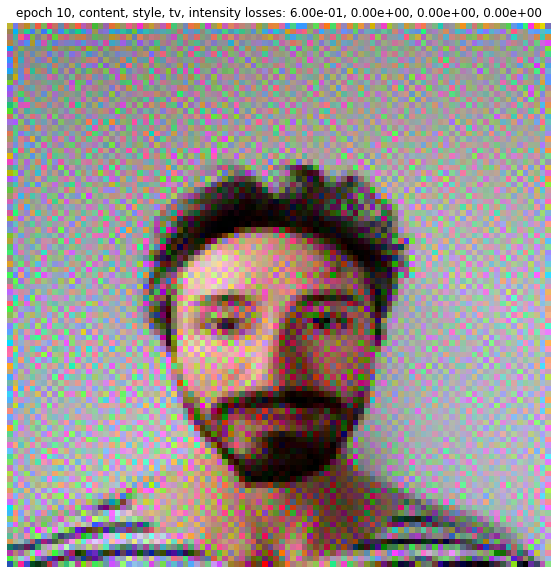

In [37]:
def get_regularizer_refs(im):
    eps = 1e-10
    L2 = torch.sqrt(im[:,0,:,:]**2 + im[:,1,:,:]**2 + im[:,2,:,:]**2 + eps)
    B = L2.mean()

    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
    V = L2.mean()
    return B, V


intensity_ref, TV_ref = get_regularizer_refs(im_style)

def get_intensity_loss(im, B=1.0):
    alpha = 6
    H = im.shape[2]
    W = im.shape[3]
    eps = 1e-10
    L2 = torch.sqrt(im[:,0,:,:]**2 + im[:,1,:,:]**2 + im[:,2,:,:]**2 + eps)
    loss = 1./H/W/(B**alpha) * torch.sum(L2**alpha)
    return loss


def get_TV_loss(im, V=1.0):
    beta = 1.5 # Can be between 1 and 2
    H = im.shape[2]
    W = im.shape[3]
    C = im.shape[1]
    eps = 1e-10 # avoids accidentally taking the sqrt of a negative number because of rounding errors
    
    # # total variation
    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
    # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
    # L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2) 
    L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
    # V = L2.mean()
    TV = torch.sum(L2**beta) # intensity regularizer
    # print(TV)
    # print(d_dx[0,0,0,0],d_dy[0,0,0,0])
    loss = 1./H/W/(V**beta) * TV
    # loss = L2.sum()
    # loss = 1./H/W/C * torch.sum(d_dx[:,:,:,1:]**2) + torch.sum(d_dy[:,:,1:,:]**2) 
    # print((d_dx[:,:,:,1:]**2).min(),(d_dy[:,:,1:,:]**2).min(),L2[0,0,0,0], V, TV, loss)
    # loss = 0.0
    # loss = 1./H/W * torch.sum(d_dx**2) + torch.sum(d_dy**2)

    return loss

fig, ax = plt.subplots(1,1,figsize=[10,10])

def closure_small():
    # im_gen.smooth(k=5e-2)
    im_generated = im_gen()
    
    fm_gen_style = get_feature_maps(im_generated, style_layer_list, gen=True)
    fm_gen_content = get_feature_maps(im_generated, content_layer, gen=True) # having to go through the network again is a bit ugly
    gram_gen = get_gram(fm_gen_style)
    content_loss = get_content_loss(fm_content, fm_gen_content)
    style_loss = get_style_loss(gram_style,gram_gen)
    tv_loss = get_TV_loss(im_generated, TV_ref)
    # print(tv_loss)
    int_loss = get_intensity_loss(im_generated)

    return content_loss, style_loss, tv_loss, int_loss

def closure():
    optimizer.zero_grad()
    content_loss, style_loss, tv_loss, int_loss = closure_small()
    loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss + int_weight*int_loss
    loss.backward()
    return loss

last_loss = 1e10
jit_i, jit_j = 0, 0,
frame = 0
for i in range(1000):    
#     im_gen.jitter()
    
    optimizer.step(closure)
    scheduler.step()
    # adjust weights
    content_loss, style_loss, tv_loss, int_loss = closure_small()
    if tv_weight*tv_loss>0.5*(style_weight*style_loss+content_weight*content_loss):
        tv_weight *= 0.75
    if tv_weight*tv_loss<0.1*(style_weight*style_loss+content_weight*content_loss):
        tv_weight *= 2.0
    if i%1==0:
        with torch.no_grad():
#             content_loss, style_loss, tv_loss = closure_small()
            loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss + int_weight*int_loss
            
            imnew = postprocess(im_gen())
            
            plt.clf()
            plt.imshow(imnew)
            plt.axis("off")
            plt.title(f"epoch {i:02d}, content, style, tv, intensity losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}, {int_weight*int_loss:.2e}")
            clear_output(wait = True)
            display(fig)
            # plt.savefig(f"/content/gdrive/MyDrive/00_Data_science/Neural_style_transfer/Output/Frame{frame:05d}")
            # frame += 1

            


            # if loss<abs_loss_limit:
            #     clear_output(wait = True)
            #     print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
            #     break
            # if torch.abs(last_loss-loss)<rel_loss_limit:
            #     clear_output(wait = True)
            #     print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
            #     break
                
#             last_loss = loss

# plt.clf()
# plt.imshow(imnew)
# plt.title(f"epoch {i:02d}, content, style, tv, intensity losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}, {int_weight*int_loss:.2e}")
# # plt.savefig(f"./Output/Frame{frame:05d}")
# frame += 1